In [165]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import LabelEncoder
import theano
print(theano.config.device)

np.random.seed(42)
pm.set_tt_rng(42)


cuda


In [172]:
C = 6
J = 2
N = np.array([1000, 100, 30])
S = len(N)

## MCMC vanilla LDA

In [192]:
def encode_counts(X):
    # turn counts of position into word-style encoding
    # https://laptrinhx.com/topic-modeling-with-pymc3-398251916/
    S, C = X.shape
    return [np.repeat(range(C), X[i].astype(int)) for i in range(S)]

In [193]:
# Generate data
theta_gen = np.array([0.3, 0.7, 0.8, 0.2, .5, .5]).reshape(S, J)
phi_gen = np.array([0.25, 0.6, 0.05, 0.05, 0, 0.05, 1,0,0,0,0,0]).reshape(J, C)
X = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, theta_gen@phi_gen)])
X = encode_counts(X)

In [194]:
with pm.Model() as model:
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(J, C))
    
    for i in range(S):
        # activities
        theta = pm.Dirichlet(f"theta_{i}", a=alpha)
        
        # pick signature for each word
        z = pm.Categorical(f"z_{i}", p=theta, shape=X[i].shape)
        
        # pick word acording to topic probs
        w = pm.Categorical(f"w_{i}", p=phi[z], observed=X[i])

In [209]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [195]:
with model:    
    trace = pm.sample(1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta_2, theta_1, theta_0, phi]
>BinaryGibbsMetropolis: [z_0, z_1, z_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 513 seconds.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.690097628615274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6816901532271027, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [201]:
with pm.Model() as model_parallel:
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(J, C))
    
    # activities
    theta = pm.Dirichlet("theta", a=alpha, shape=(S, J))
    
    for i in range(S):
        # pick signature for each word
        z = pm.Categorical(f"z_{i}", p=theta[i], shape=X[i].shape)
        
        # pick word acording to topic probs
        w = pm.Categorical(f"w_{i}", p=phi[z], observed=X[i])

In [204]:
with model_parallel:    
    trace2 = pm.sample(1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, phi]
>BinaryGibbsMetropolis: [z_0, z_1, z_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 459 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.667387216373141, but should be close to 0.8. Try to increase the number of tuning steps.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6821992914463544, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


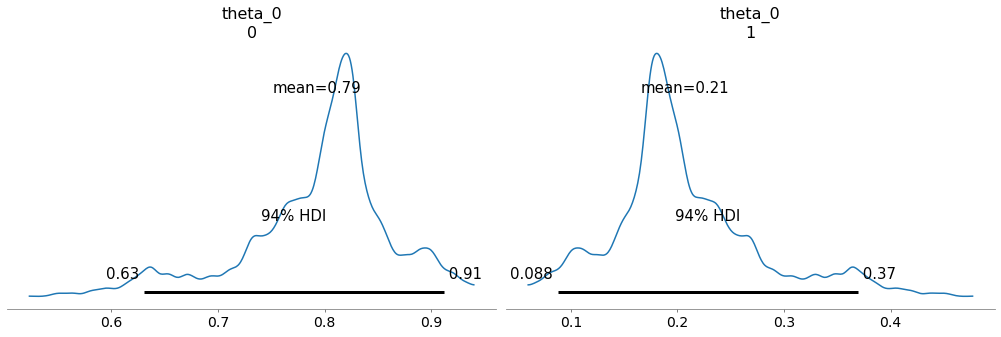

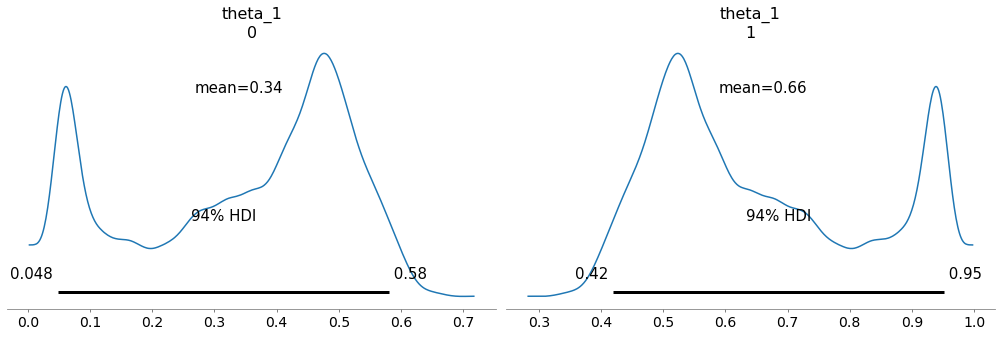

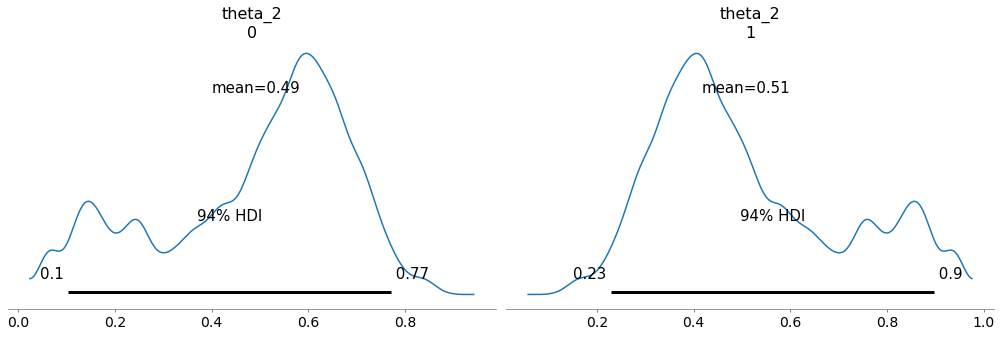

In [198]:
for i in range(S):
    az.plot_posterior(trace, var_names=[f'theta_{i}']);

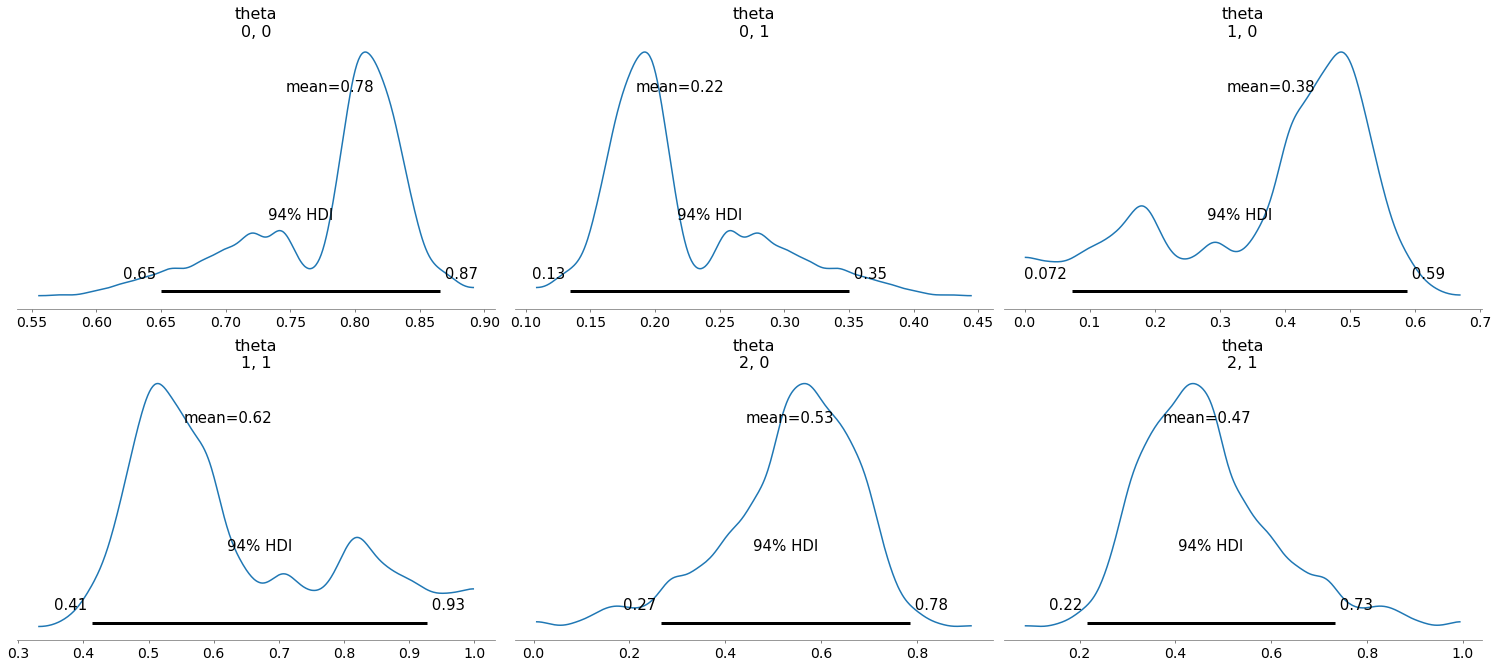

In [208]:
az.plot_posterior(trace2, var_names=['theta']);

KeyError: 'phi'

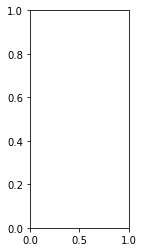

In [146]:
import seaborn as sns

mut_types = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']

def plot_phi_estimates(trace):
    
    for j in range(J):
        plt.subplot(1, 3, i+1)
        for c in range(C):
            sns.distplot(trace['phi'][:, j, c], kde=True, hist=False, label=mut_types[c])
            plt.ylim([0, 10])
        plt.title(f'Phi density estimates for topic {j}')
        plt.legend(mut_types)
        
plot_phi_estimates(trace)

## ADVI 'collapsed' LDA

In [175]:
# Hyper-parameter for uniform Dirichlet prior
alpha = np.ones(J)

# Hyper-parameter for sparse Dirichlet prior
beta = np.ones(C) * 0.2

# Generate data
theta_gen = pm.Dirichlet.dist(a=alpha).random(size = S)
phi_gen = pm.Dirichlet.dist(a=beta, shape=(J, C)).random(size = 1).squeeze()
X = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, theta_gen@phi_gen)])

In [107]:
with pm.Model() as model:
    # Global topic distribution
    theta = pm.Dirichlet('theta', a=alpha)
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(J, C))
    
    for i in range(S):
        # Words of document
        w = pm.Multinomial(f'sample_{i}', n = N[i], p = theta@phi, observed=X[i])


In [108]:
w

sample_2 ~ Multinomial

In [ ]:
phi

In [109]:
w.tag.test_value

array([ 0,  1,  5,  6, 15,  3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


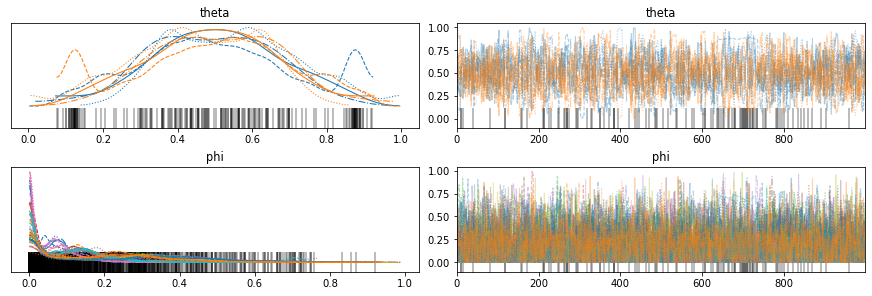

In [98]:
with model:
    trace = pm.sample(1000, return_inferencedata=True)
    pm.plot_trace(trace);



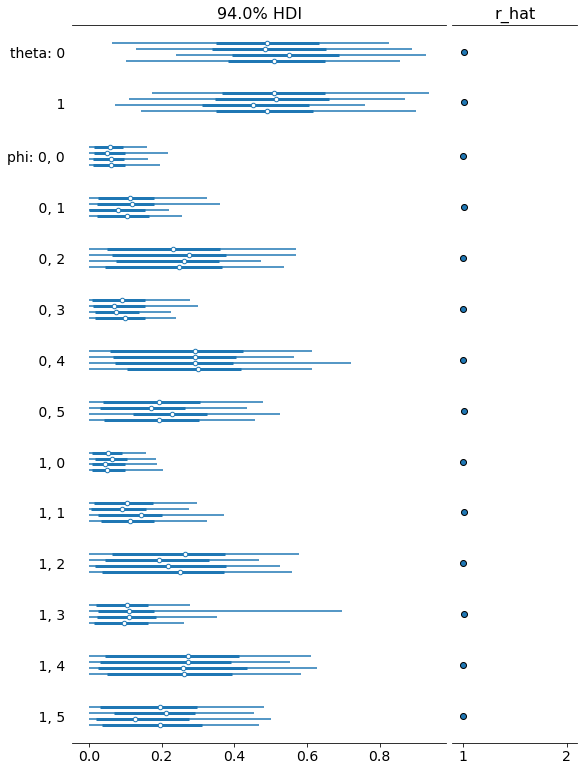

In [110]:
az.plot_forest(trace, r_hat=True);

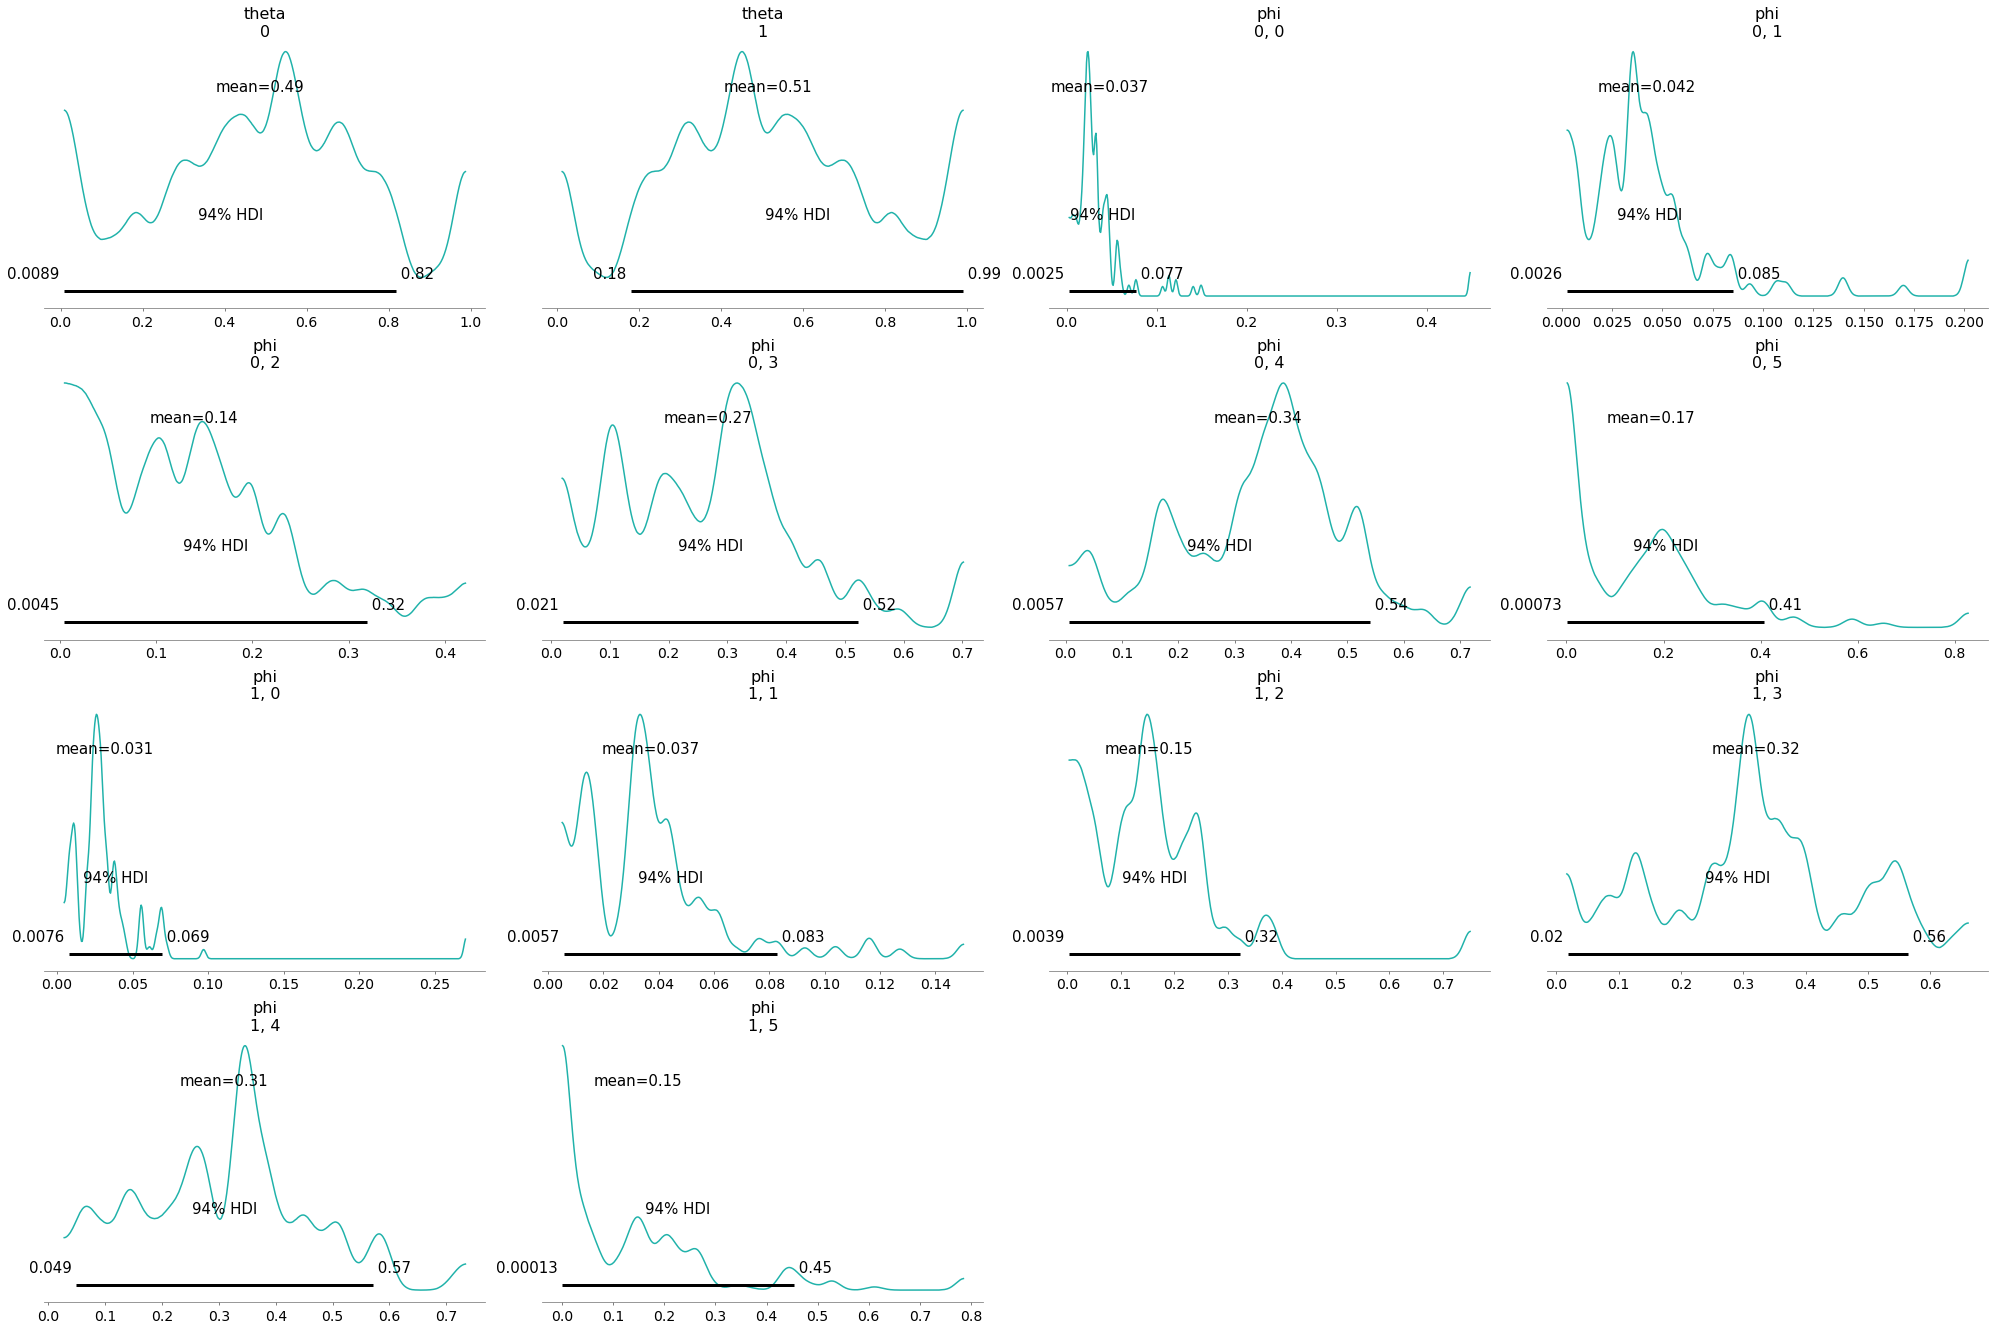

In [124]:
with model:
    mean_field = pm.fit(method=pm.SVGD(n_particles=100, jitter=1.0), callbacks=[pm.callbacks.CheckParametersConvergence()])
    pm.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");


In [125]:
dir(mean_field)

['_Group__name_registry',
 '_Group__param_registry',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_group__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__param_spec__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batched',
 '_cache',
 '_check_trace',
 '_check_user_params',
 '_finalize_init',
 '_group_class',
 '_initial_type',
 '_input_type',
 '_local',
 '_new_initial',
 '_new_initial_shape',
 '_rng',
 '_scale_cost_to_minibatch',
 '_single_symbolic_varlogp_and_datalogp',
 '_sized_symbolic_varlogp_and_datalogp',
 '_user_params',
 '_vfam',
 'alias_names',
 'all_histograms',
 'any_histograms',
 'batched',
 'bdim',
 'bij',
 'collect',
 'cov',
 'create_shared_params',
 'datalogp',
 'datalogp_norm

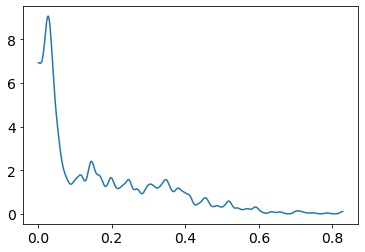

In [126]:
plt.figure()
trace = mean_field.sample(10000)
az.plot_dist(trace["phi"]);

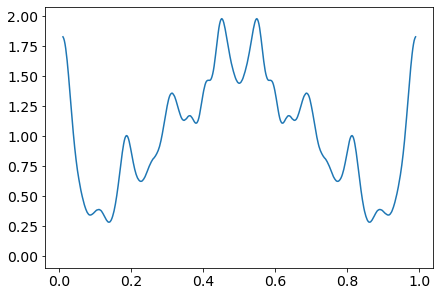

In [127]:
az.plot_dist(trace["theta"]);